In [331]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload


## Graph


In [332]:
from graphviz import Digraph


class Graph:
    def draw(self, root):
        def trace(_value):
            # Set of all nodes and edges in a graph.
            nodes, edges = set(), set()

            def build(v):
                if v not in nodes:
                    nodes.add(v)
                    for child in v.children:
                        if child is not None:
                            edges.add((child, v))
                            build(child)
            build(_value)
            return nodes, edges

        graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

        node, edges = trace(root)

        for value in node:
            if (value.data is None):
                continue

            uid = str(id(value))
            # Create a rectangular node for each value.
            graph.node(name=uid, label="{ " + "{label} | data {data:.4f} | grad {grad:.4f}".format(
                label=value.label, data=value.data or 0, grad=value.grad) + " }", shape='record', )

            if value._op:
                # If this value is the result of an operation, create a node for the operation.
                graph.node(name=uid + value._op, label=value._op,
                           color='gray', shape='circle', fontcolor='gray')
                # and connect this node to it.
                graph.edge(uid + value._op, uid)

        for v1, v2 in edges:
            if (v1.data is None) or (v2.data is None):
                continue

            # Connect 1st value to the op node of the 2nd value.
            graph.edge(str(id(v1)), str(id(v2)) + v2._op)

        return graph

    def __call__(self, root):
        return self.draw(root)


graph = Graph()


## Value


In [333]:
from typing import Callable, TypeVar

TValue = TypeVar("TValue", bound="Value")


class Value:
    """
    A node in the computation graph.
    """
    data: float
    """The value of this node"""
    grad: float
    """The gradient of this node"""
    children: tuple[TValue]
    """The children nodes in the computation graph"""
    _backward: Callable[..., None]
    """Go backwards in the computation graph and compute the gradient of this node."""
    _op: str
    """The operation symbol for this node"""
    label: str
    """An optional label for this node"""

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.children = _children
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def _topological_sort(self, root: TValue):
        """Perform a topological sort, going backwards from the given node. Returns a list of nodes in the reversed order of execution."""

        def build(v: TValue):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    if isinstance(child, Value):
                        build(child)
                sorted.append(v)

        sorted: list[TValue] = []
        visited: set[TValue] = set()

        build(root)

        return reversed(sorted)

    def backward(self):
        """Perform backpropagation on the computation graph"""
        sorted = self._topological_sort(self)

        self.grad = 1.0  # Start with the gradient of 1 for the root node.

        for v in sorted:
            v._backward()

    def _operate(self, other: TValue, fn: callable, op: str, backward=lambda: None):
        other = Value(other) if (not isinstance(
            other, Value) and not None) else other

        # Create a new node from applying the given operation between 'self' and 'other'.
        next = Value(fn(self.data, other.data),
                     (self, other), op)

        # https://www.mathsisfun.com/calculus/derivatives-rules.html
        next._backward = lambda: backward(next, self, other)

        return next

    def __neg__(self): return self * -1

    # Below are overloaded operators for basic mathematical operations:
    def __truediv__(self, other):
        def _backward(next, _self, _other):
            _self.grad = 1.0 / _other.data * next.grad
            _other.grad = -_self.data / _other.data**2 * next.grad

        return self._operate(other, lambda x, y: x * y ** -1, '/', _backward)

    def __add__(self, other):
        """Add two values together."""
        def _backward(next, _self, _other):
            _self.grad += 1.0 * next.grad
            _other.grad += 1.0 * next.grad

        return self._operate(other, lambda x, y: x + y, '+', _backward)

    def __radd__(self, other): return self + other

    def __sub__(self, other): return self + (-other)

    def __mul__(self, other):
        """Multiply two values."""
        def _backward(next, _self, _other):
            _self.grad += _other.data * next.grad
            _other.grad += _self.data * next.grad

        return self._operate(other, lambda x, y: x * y, '*', _backward)

    def __rmul__(self, other): return self * other

    def __pow__(self, other):
        """Raise a value to a power."""
        def _backward(next, _self, _other):
            _self.grad += _other.data * \
                _self.data ** (_other.data - 1) * next.grad

        return self._operate(other, lambda x, y: x ** y, '**', _backward)

    def exp(self):
        """Exponential of a value."""
        def _backward(next, _self, _other=None):
            _self.grad = next.data * next.grad

        return self._operate(None, lambda x, y=None: math.exp(x), 'exp', _backward)

    def tanh(self):
        """Hyperbolic tangent of a value."""
        def _backward(next, _self, _other=None):
            _self.grad = (1 - math.tanh(_self.data)**2) * next.grad

        return self._operate(None, lambda x, y=None: (math.exp(2*x) - 1) / (math.exp(2*x) + 1), 'tanh', _backward)


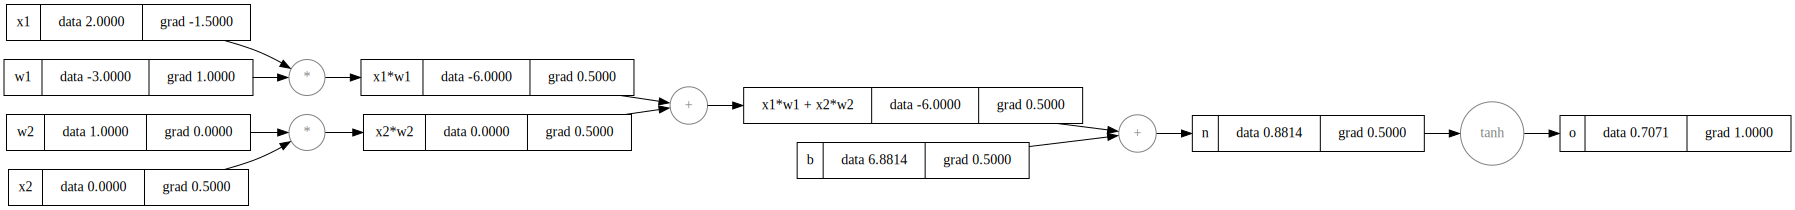

In [334]:
# Neuron inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Neuron weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Neuron
n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()

graph(o)


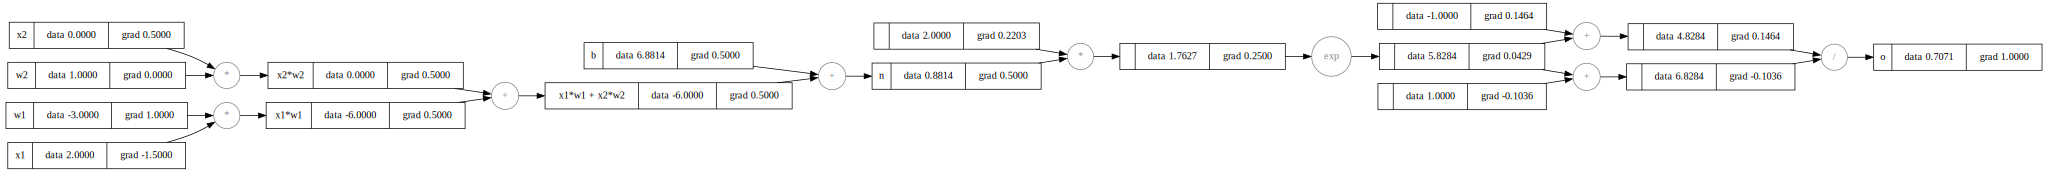

In [335]:
# Neuron inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Neuron weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Neuron
n = x1w1x2w2 + b
n.label = 'n'

e: Value = (n*2).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
graph(o)


In [336]:
import torch

x1 = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.float64, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
b = torch.tensor([6.8813735870195432], dtype=torch.float64, requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward(create_graph=True)

print('---')
print('x1.grad', x1.grad.item())
print('w1.grad', w1.grad.item())
print('x2.grad', x2.grad.item())
print('w2.grad', w2.grad.item())


0.7071067811865476
---
x1.grad -1.4999999999999998
w1.grad 0.9999999999999999
x2.grad 0.49999999999999994
w2.grad 0.0


# Creating an MLP


In [337]:
from typing import List
import random


class Neuron:
    """Defines a neuron with a list of weights, a bias and number of inputs."""
    weights: List[Value]
    bias: Value

    def __init__(self, number_of_inputs: int):
        self.weights = [Value(random.uniform(-1, 1))
                        for _ in range(number_of_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def forward(self, inputs: List[Value]) -> Value:
        assert len(inputs) == len(self.weights)
        return sum([weight * input for weight, input in zip(self.weights, inputs)]) + self.bias

    def __call__(self, inputs: List[Value]) -> Value:
        # weight * inputs + bias
        activation = sum((weight * input for weight,
                         input in zip(self.weights, inputs)), self.bias)

        return activation.tanh()

    def parameters(self):
        return self.weights + [self.bias]


class Layer:
    """Defines a layer of neurons."""
    neurons: List[Neuron]

    def __init__(self, number_of_inputs_per_neuron: int, number_of_neurons: int):
        self.neurons = [Neuron(number_of_inputs_per_neuron)
                        for _ in range(number_of_neurons)]

    def __call__(self, inputs: List[Value]):
        output = [neuron(inputs) for neuron in self.neurons]

        return output[0] if len(output) == 1 else output

    def parameters(self):
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]

class MLP:
    """Defines a multi-layer perceptron."""
    layers: List[Layer]

    def __init__(self, number_of_neurons: int, number_of_outputs: List[int]):
        # Example: number_of_neurons 3, number_of_outputs: [4, 4, 1]
        #
        # Result:3 inputs, 4 neurons in first layer, 4 neurons in second layer, 1 output
        #
        #  Layer       Layer        Layer        Layer
        #  [Input] --> [Neuron] --> [Neuron]
        #  [Input] --> [Neuron] --> [Neuron] --> Output
        #  [Input] --> [Neuron] --> [Neuron]
        #          --> [Neuron] --> [Neuron]
        layers = [number_of_neurons] + number_of_outputs

        self.layers = [Layer(layers[i], layers[i+1])
                       for i in range(len(number_of_outputs))]

    def __call__(self, inputs: List[Value]):
        """Go through each layer and return the output."""
        for layer in self.layers:
            inputs = layer(inputs)

        return inputs

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]


inputs = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
o = mlp(inputs)
o.backward()
# graph(o)


# Trying out the MLP

- `xs` is the data
- `ys` is the expected data


In [338]:
# Neuron inputs.
xs = [
    [14.0, 22.0, -1.0],
    [3.0, -3.0, 44.3],
    [0.5, 10.0, 9.0],
    [1.0, 21.0, -1.0]
]

# Desired targets
ys = [
    -1,
    -1,
    -1,
    -1
]

def calculate_loss(prediction: list[float]) -> list[Value]:
    """Calculate the loss between the desired targets and the predicted targets."""
    return sum([(output - groundTruth)**2 for groundTruth, output in zip(ys, prediction)])


**Training**

In [339]:
steps = 20

size = 0.01

for k in range(steps):
    # forward pass

    ypred = [mlp(x) for x in xs]
    loss = calculate_loss(ypred)

    for parameter in mlp.parameters():
        parameter.grad = 0

    loss.backward()

    # update weights
    for parameter in mlp.parameters():
        parameter.data -= size * parameter.grad

    print(f"Training step {k} || Loss {loss.data:.4f}", k)

    if (k == steps -1 ):
        print("-----------")
        print("Final prediction:", ypred)
        print("Final loss:", loss.data)


Training step 0 || Loss 4.1003 0
Training step 1 || Loss 3.3834 1
Training step 2 || Loss 2.8192 2
Training step 3 || Loss 2.3406 3
Training step 4 || Loss 1.9254 4
Training step 5 || Loss 1.5671 5
Training step 6 || Loss 1.2669 6
Training step 7 || Loss 1.0245 7
Training step 8 || Loss 0.8344 8
Training step 9 || Loss 0.6876 9
Training step 10 || Loss 0.5747 10
Training step 11 || Loss 0.4873 11
Training step 12 || Loss 0.4190 12
Training step 13 || Loss 0.3649 13
Training step 14 || Loss 0.3214 14
Training step 15 || Loss 0.2859 15
Training step 16 || Loss 0.2567 16
Training step 17 || Loss 0.2322 17
Training step 18 || Loss 0.2116 18
Training step 19 || Loss 0.1940 19
-----------
Final prediction: [Value(data=-0.9674738166706973), Value(data=-0.5949050628072259), Value(data=-0.8358175303607859), Value(data=-0.9567829197087411)]
Final loss: 0.1939834601069216


> Note: Gradient descent is iteratively doing forward pass, backward pass and then nudge the parameters.

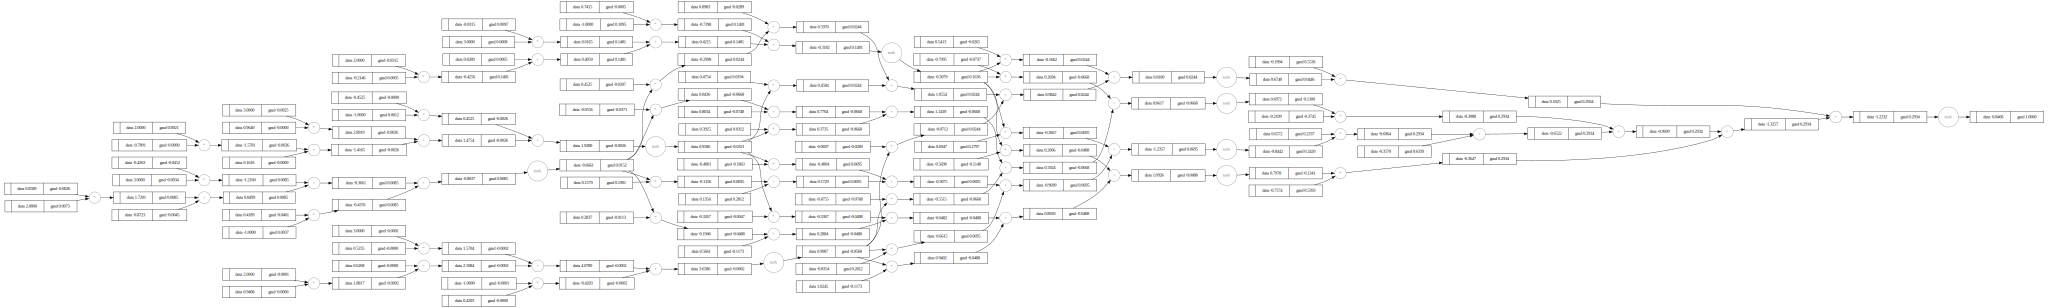

In [340]:
graph(o)